# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2) with Engineered Features


This notebook provides a clustering for the total (n2) column of the acceleration data of all trips. The exact approach can be seen here.

----
**Specification of experiment:**
- scripted and ordinary trips
- n2 column of acceleration data was used
- Euclidean Distance was calculated
- Feature Engineering with Quantiles, Standard deviation, maximum break/acceleration length

-----
**Results:**

1) KMeans Clustering:



    Estimated number of clusters: 4

    True number of clusters: 3

    Homogeneity: 0.525

    Completeness: 0.429

    V-measure: 0.472

    Adjusted MI: 0.428

    Silhouette Coefficient: 0.612

2) HDBSCAN Clustering:


    Estimated number of clusters: 3

    True number of clusters: 3

    Homogeneity: 0.489

    Completeness: 0.403

    V-measure: 0.442

    Adjusted MI: 0.402

    Silhouette Coefficient: 0.603

*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import hdbscan
from sklearn.preprocessing import scale
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_silhouette_scores



%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
%aimport models.cluster
from models.cluster import get_clustering_performance
from models.cluster import Clustering

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]

distance_matrix = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")
distances_only = distance_matrix.drop(categorical_columns,axis=1)

--------
# Feature Engineering

## Calculate Maximum Break Length as Longest decreasing pattern

Calculate break duration in seconds

In [4]:
trips_copy = trips_cut_per_30_sec.drop(categorical_columns,axis=1)
longest_decreasing_patterns = calculate_maximum_break_length(trips_copy,
                                                             threshold=3)


## Calculate Maximum Acceleration Length == Longest increasing pattern

Calculate acceleration duration in seconds

In [5]:
longest_increasing_patterns = calculate_maximum_acceleration_length(trips_copy,
                                                             threshold=3)


## Summary Statistics of euclidean distances:

In [6]:
percentiles=[0.1*(i+1) for i in range(10)]
summary = distances_only.transpose().describe(percentiles=percentiles).T
summary = summary.drop(["count","min","max","mean"],axis=1)
summary.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,45.571907,6.592725,11.671220,14.280400,16.096563,18.216037,25.715053,73.099327,103.760440,118.078920,168.729605
1,45.631845,6.939125,10.390683,12.894615,14.476116,16.686338,24.427714,72.553589,103.159206,117.537131,167.822824
2,45.805061,5.851265,10.500663,13.029385,14.768853,16.914233,24.796279,72.703468,103.401745,117.751214,167.915836
3,46.055116,6.446537,8.512491,11.028059,12.726118,15.134580,23.282617,71.996049,102.586694,117.039126,166.760233
4,45.833305,7.200553,8.925239,11.132777,12.790077,15.216717,23.310149,71.824274,102.428992,117.013389,166.822958


In [7]:
summary["longest_break_period"] = np.array(longest_decreasing_patterns,dtype=np.float32)
summary["longest_acceleration_period"] = np.array(longest_increasing_patterns,dtype=np.float32)
for colname in categorical_columns:
    summary[colname] = distance_matrix[colname]


### Summary of maximum break period and longest acceleration period per transport mode

In [8]:
summary.groupby("mode").describe()[["longest_break_period","longest_acceleration_period"]]

longest_break_period                                           \
                     count      mean       std  min  25%  50%   75%   
mode                                                                  
METRO                596.0  0.746812  0.987114  0.2  0.2  0.4  0.70   
TRAM                 706.0  1.046671  3.446498  0.0  0.2  0.4  0.75   
WALK                 840.0  0.686309  0.837167  0.2  0.2  0.4  0.80   

                 longest_acceleration_period                                 \
             max                       count      mean       std  min   25%   
mode                                                                          
METRO   7.800000                       596.0  3.267282  3.301566  0.0  1.20   
TRAM   70.800003                       706.0  3.901629  4.434204  0.2  1.05   
WALK   10.000000                       840.0  2.683750  2.193476  0.9  1.20   

                            
       50%  75%        max  
mode                        
METRO  1.4  6.0  34.200001  
TRAM   1.6  6.2  51.500000  
WALK   1.4  4.4  11.550000

### Choose which features to use

In [9]:
features_used = summary

### Prepare features for clustering

In [10]:
features_used = features_used.drop(categorical_columns,axis=1)
features_used = pd.DataFrame(scale(features_used),columns=features_used.columns)
features_used.head(2)

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%,longest_break_period,longest_acceleration_period
0,0.781653,-0.729561,-0.656575,-0.631521,-0.638780,-0.673788,-0.680514,-0.577151,-0.528720,-0.525668,-0.312432,-0.246579,-0.658489
1,0.786974,-0.722130,-0.684420,-0.661966,-0.675033,-0.708919,-0.712014,-0.597806,-0.557837,-0.553245,-0.368068,-0.104845,-0.570594


------
# Model Building

## Create Base Model with KMeans Clustering

Use summaries of each distance

In [11]:
from sklearn.cluster import KMeans
random_state = 0

clustering_labels = []
numbers_of_k = [3,4,5,6]
highest_silh_score = 0.0
best_param = 0.0
for k in numbers_of_k:
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(features_used)
    helper_score = Clustering.calculate_silhouette_score(features_used,kmeans.labels_)
       
    if helper_score > highest_silh_score:
        highest_silh_score = helper_score
        best_param = k
    clustering_labels.append(kmeans.labels_)

### Plot Silhouette Score for different k

For n_clusters = 3 The average silhouette_score is : 0.60672402925


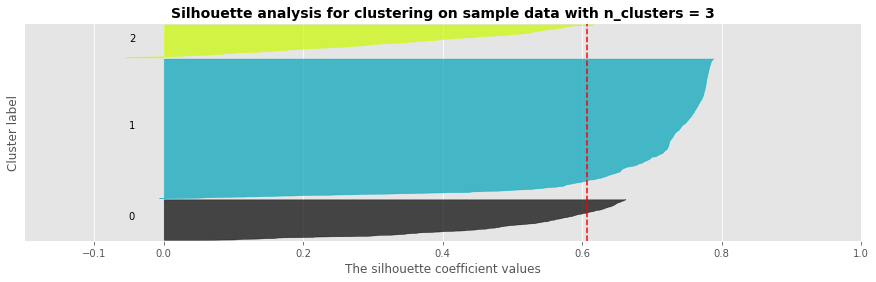

For n_clusters = 4 The average silhouette_score is : 0.612241143169


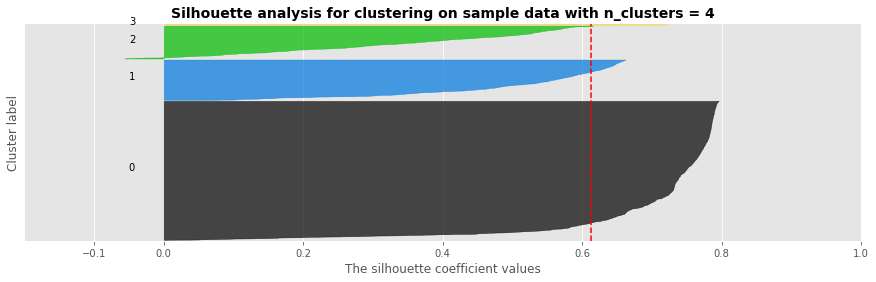

For n_clusters = 5 The average silhouette_score is : 0.485026511338


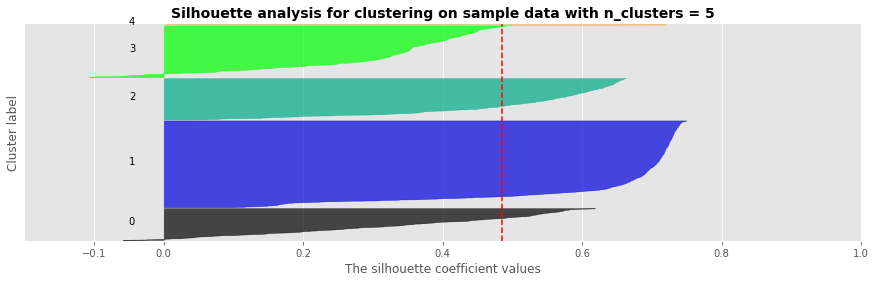

For n_clusters = 6 The average silhouette_score is : 0.485796201058


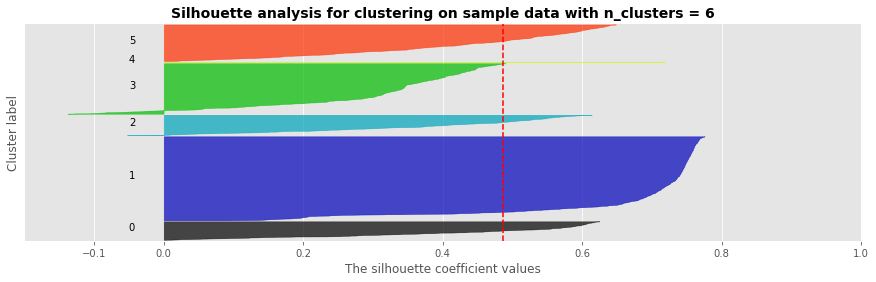

In [12]:
plot_silhouette_scores(features_used, clustering_labels, figsize=(15,4))

Use best parameter setting:


In [13]:
kmeans = KMeans(n_clusters=best_param, random_state=random_state).fit(features_used)
distance_matrix["cluster_labels"]=kmeans.labels_

-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [14]:
cluster_performance = get_clustering_performance(features_used, distance_matrix["cluster_labels"],
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 4

 - True number of clusters: 3

 - Homogeneity: 0.525

 - Completeness: 0.429

 - V-measure: 0.472

 - Adjusted MI: 0.428

 - Silhouette Coefficient: 0.612

## Visualise Clustering on 2D - TSNE Plot:

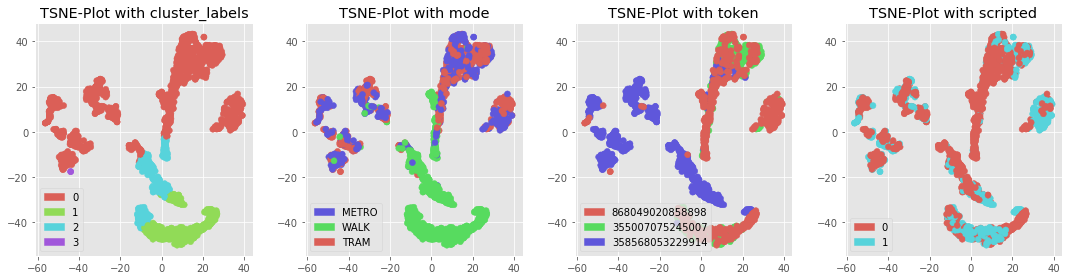

In [15]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings, perplexity=50, learning_rate=500)

## Inspect the distribution of modes to cluster label for all trips

In [16]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,count_cluster_3,mode
0,587.0,0.0,9.0,0.0,METRO
1,112.0,407.0,321.0,0.0,WALK
2,702.0,0.0,2.0,2.0,TRAM


### Plot distribution of cluster labels for transport modes

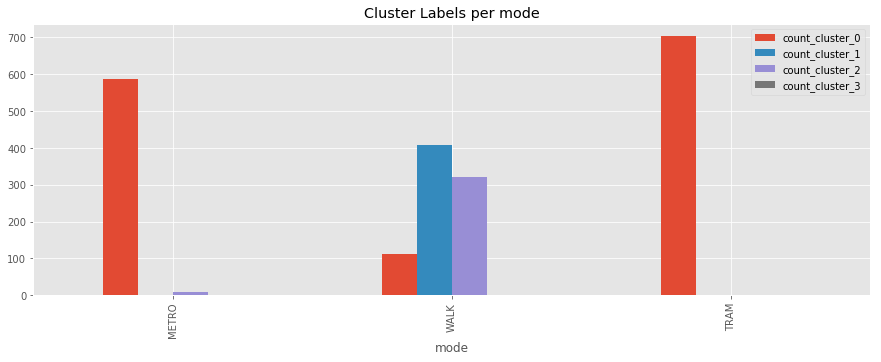

In [17]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for scripted and ordinary


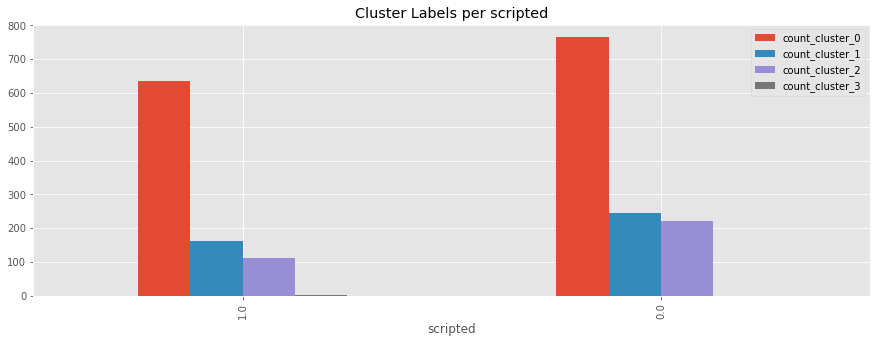

In [18]:
plot_distribution_of_cluster_labels_for_target("scripted", distance_matrix)

### Plot distribution of cluster labels for tokens

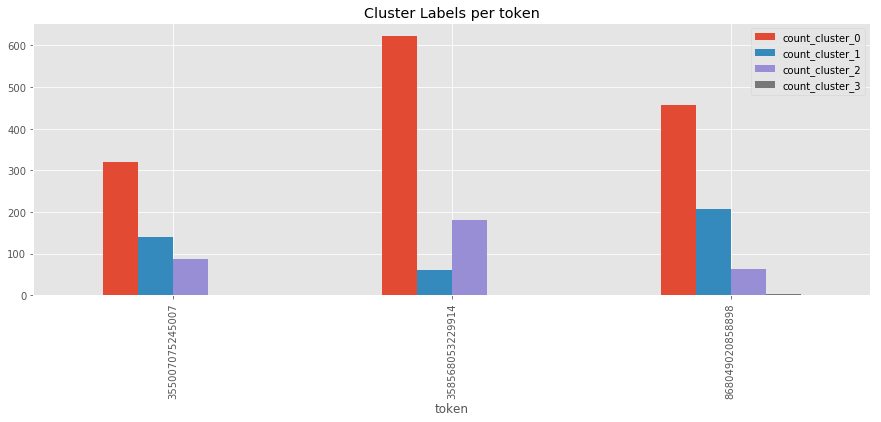

In [19]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

## Create Model with HDBSCAN Clustering

-----
## Summary Statistics for HDBSCAN Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [20]:
clustering_labels = []
min_cluster_sizes = [10,15,250]
highest_silh_score = 0.0
best_param = 0.0
for k in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=k, gen_min_span_tree=True)
    clusterer.fit(features_used)
    helper_score = Clustering.calculate_silhouette_score(features_used,clusterer.labels_)
       
    if helper_score > highest_silh_score:
        highest_silh_score = helper_score
        best_param = k
    clustering_labels.append(clusterer.labels_)

### Silhouette Score for different min_cluster_sizes

For n_clusters = 16 The average silhouette_score is : 0.0392984967126


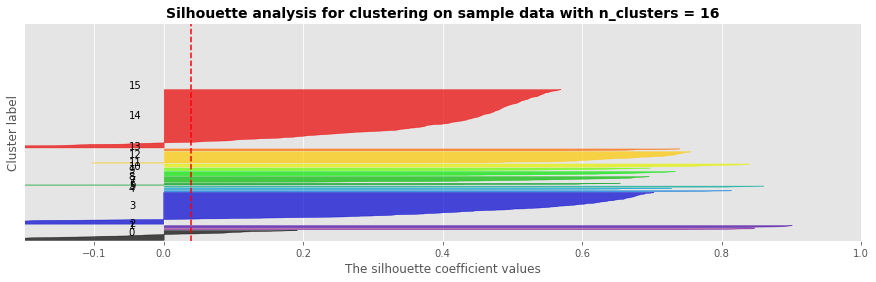

For n_clusters = 10 The average silhouette_score is : 0.14590646484


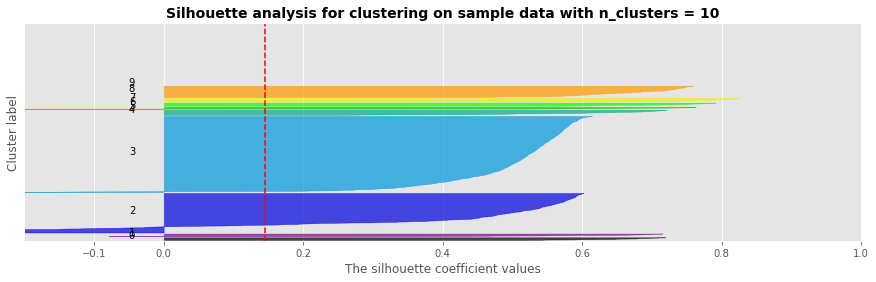

For n_clusters = 3 The average silhouette_score is : 0.603197079634


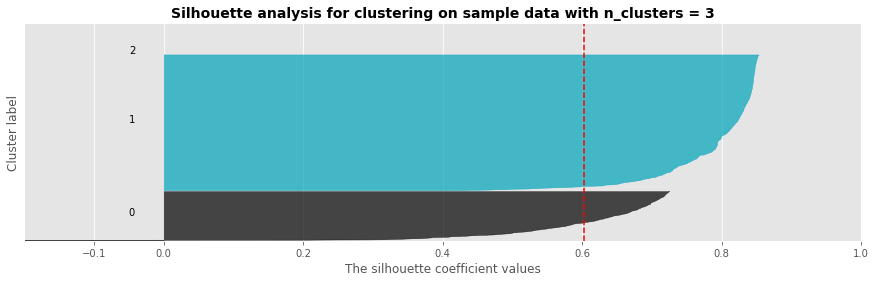

In [21]:
plot_silhouette_scores(features_used, clustering_labels, figsize=(15,4))

Use best solution:

In [22]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_param, gen_min_span_tree=True)
clusterer.fit(features_used)
distance_matrix["cluster_labels"]=clusterer.labels_


In [23]:
cluster_performance = get_clustering_performance(features_used, distance_matrix["cluster_labels"],
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.489

 - Completeness: 0.403

 - V-measure: 0.442

 - Adjusted MI: 0.402

 - Silhouette Coefficient: 0.603

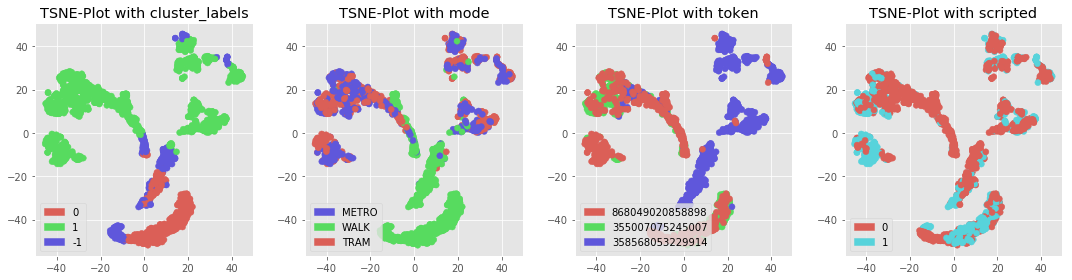

In [24]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings, perplexity=50, learning_rate=500)

## Inspect the distribution of modes to cluster label for all trips

In [25]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_-1,count_cluster_0,count_cluster_1,mode
0,19.0,1.0,576.0,METRO
1,248.0,488.0,104.0,WALK
2,24.0,0.0,682.0,TRAM


### Plot distribution of cluster labels for transport mode


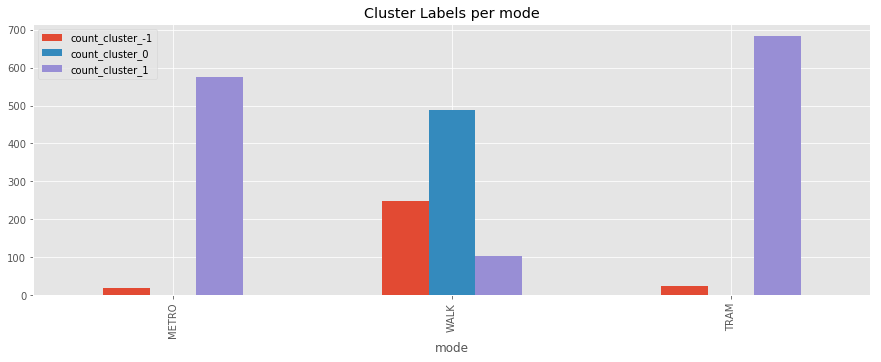

In [26]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for scripted and ordinary


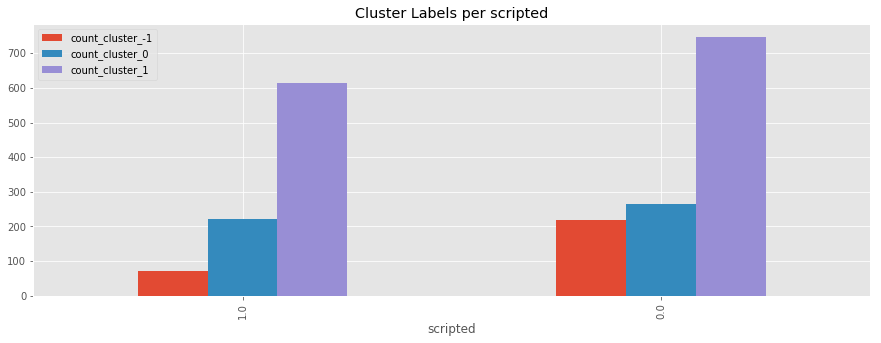

In [27]:
plot_distribution_of_cluster_labels_for_target("scripted", distance_matrix)

### Plot distribution of cluster labels for token

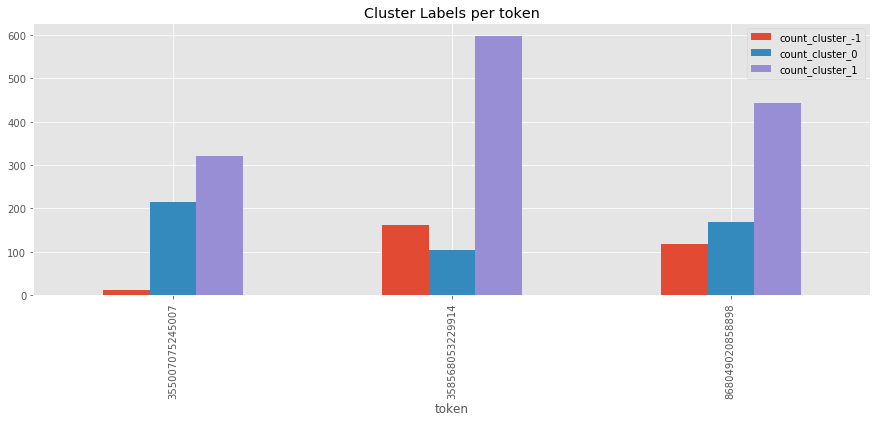

In [28]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

In [29]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)